In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import os
from scipy.signal import chirp
from simplekml import Kml
import time


# %matplotlib widget

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "font.family" : "serif",
          "font.serif" : ["times new roman"],
          "figure.dpi" : 150}
plt.rcParams.update(params)

# %matplotlib widget
%matplotlib inline


In [2]:
## finding files loading into list  ###

# directory = r'\\Sentinel\home\CBand_Backyard_sept12' 
# directory = r'C:\Users\erics\Downloads\nh0915'
directory = r'\\seasat\Projects\SNOWWI\SNOWWI_NH\NH_Flight_December\20231215T144359'
# directory = r'\\seasat\Projects\SNOWWI\Colorado_January\20240205T020242\chan0'

key = 'fl5'

fileList = os.listdir(directory)
files = []

for name in fileList:  ## finding all files in the directory with the desired keyword
    if key and '.dat' in name:
        files.append(os.path.join(directory, name))
              
# files.sort(key=os.path.getctime)      
# files = sorted(files, key=lambda x: int(x.split('.')[-2]))
files = sorted(files, key=lambda x: int(x.split('_')[-1].split('.')[0]))


print(f'Files with keyword: {key}')
print('-----------------------------------------------------------------------------------')

for f in files:
    print(f)

Files with keyword: fl5
-----------------------------------------------------------------------------------
\\seasat\Projects\SNOWWI\SNOWWI_NH\NH_Flight_December\20231215T144359\rcv_0_1151496015.371883.dat
\\seasat\Projects\SNOWWI\SNOWWI_NH\NH_Flight_December\20231215T144359\rcv_500_1151496015.871883.dat
\\seasat\Projects\SNOWWI\SNOWWI_NH\NH_Flight_December\20231215T144359\rcv_1500_1151496016.871883.dat
\\seasat\Projects\SNOWWI\SNOWWI_NH\NH_Flight_December\20231215T144359\rcv_1000_1151496016.371883.dat
\\seasat\Projects\SNOWWI\SNOWWI_NH\NH_Flight_December\20231215T144359\rcv_2000_1151496017.371883.dat
\\seasat\Projects\SNOWWI\SNOWWI_NH\NH_Flight_December\20231215T144359\rcv_2500_1151496017.871883.dat
\\seasat\Projects\SNOWWI\SNOWWI_NH\NH_Flight_December\20231215T144359\rcv_3000_1151496018.371883.dat
\\seasat\Projects\SNOWWI\SNOWWI_NH\NH_Flight_December\20231215T144359\rcv_3500_1151496018.871883.dat
\\seasat\Projects\SNOWWI\SNOWWI_NH\NH_Flight_December\20231215T144359\rcv_4000_115149601

### Below here need to fix so it takes in all files and reads into a single large matrix  ###

In [3]:
## importing first file of data  ###  to get file/matrix sizes

FIR = 1  ## with FIR
# FIR = 0  ## w/o FIR

file_data = []
idx = 0
total_pulses = 0

for f in files[25:125]:
    window_samps = np.fromfile(f, np.int16, offset = 0)[:]
    # window_samps = np.fromfile(f, np.int16, offset = 0)[FIR::2]  # with FIR 
    # window_samps = np.fromfile(f, np.uint16, offset = 0)[::2] 
    window_meta = np.fromfile(f, np.uint16, offset = 0)[1::2]
    window_labels = window_meta % 2

    start_idx = (np.diff(window_labels) == 1).nonzero()[0] # Use rising edges of window_labels
    n_samp = int(np.mean(np.diff(start_idx[:10])))
    temp_data = window_samps[start_idx[0]:start_idx[-1]].reshape((-1, n_samp))
    print(f'File Index: {idx} with shape {temp_data.shape}')
    file_data.append(temp_data)

    idx +=1
    total_pulses+= temp_data.shape[0]
   

File Index: 0 with shape (498, 30000)
File Index: 1 with shape (498, 30000)
File Index: 2 with shape (498, 30000)
File Index: 3 with shape (498, 30000)
File Index: 4 with shape (498, 30000)
File Index: 5 with shape (498, 30000)
File Index: 6 with shape (498, 30000)
File Index: 7 with shape (498, 30000)
File Index: 8 with shape (498, 30000)
File Index: 9 with shape (498, 30000)
File Index: 10 with shape (498, 30000)
File Index: 11 with shape (498, 30000)
File Index: 12 with shape (498, 30000)
File Index: 13 with shape (498, 30000)
File Index: 14 with shape (498, 30000)
File Index: 15 with shape (498, 30000)
File Index: 16 with shape (498, 30000)
File Index: 17 with shape (498, 30000)
File Index: 18 with shape (498, 30000)
File Index: 19 with shape (498, 30000)
File Index: 20 with shape (498, 30000)
File Index: 21 with shape (498, 30000)
File Index: 22 with shape (498, 30000)
File Index: 23 with shape (498, 30000)
File Index: 24 with shape (498, 30000)
File Index: 25 with shape (498, 300

In [4]:
###  Plotting First Window in each file  ###
# plt.figure(figsize=(14, 6))
# plt.title('First Window From Each File')
# plt.xlabel('Samples')
# for i in file_data:
#     plt.plot(i[0])

# plt.xlim(0, file_data[0].shape[1])
# plt.grid()
# plt.show()


In [5]:
full_data = np.zeros((total_pulses, n_samp))

idx = 0
data_shape = file_data[0].shape[0]

for data in file_data:
    full_data[idx:idx+data_shape] = data
    idx += data_shape

print(f'Full Data Shape: {full_data.shape}')

Full Data Shape: (49800, 30000)


In [6]:
## Removing mean before pulse compression  ##

# row_mean = np.mean(full_data, axis=1)
# full_mean = np.mean(row_mean)

# print('Full Data Mean  :', full_mean)
# print('Mean of Each Row:', row_mean)

# full_data = full_data - row_mean[:,None]

# print('--------------------------------------------')
# print(f'Full Data Mean after removing DC: {np.mean(np.mean(full_data, axis=1))}')

In [7]:

def average_rows(matrix, N):
    # Calculate the number of resulting rows after averaging
    num_rows, num_cols = matrix.shape
    num_result_rows = num_rows // N

    # Reshape the matrix to group rows for averaging
    reshaped_matrix = matrix[:num_result_rows * N, :].reshape(num_result_rows, N, num_cols)

    # Calculate the row-wise averages
    averages = np.mean(reshaped_matrix, axis=1)

    return averages

def lowpass(data, cutoff, fs, order):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)
    
    return y

def bandpass(data, low_cutoff, high_cutoff, fs, order):
    nyq = 0.5*fs
    normal_low = low_cutoff/nyq
    normal_high = high_cutoff/nyq

    b, a = signal.butter(order, [normal_low, normal_high], btype='band', analog=False)
    y = signal.filtfilt(b, a, data)

    return y



def multilook(image, xLooks, yLooks):

    ###  Adjusts image to be able to be multilooked (no extra rows/columns)

    if image.shape[0]%yLooks != 0:
        image = image[:, :-(image.shape[0]%yLooks)]


    elif image.shape[1]%xLooks !=0:
        image = image[:, :-(image.shape[1]%xLooks)]
    
    ###  Take in an image, multilook in range and azimuth, return multilooked image  ###
    
    y_ = np.zeros_like(image[0::yLooks])
    for r in range(yLooks):
        y_ = y_ + image[r::yLooks]
        
    yLooked = y_ / yLooks

    x = np.zeros_like(yLooked[:, 0::xLooks])
    for a in range(xLooks):
        x = x + yLooked[:, a::xLooks]
        
    multilooked = x / xLooks
    return multilooked

def rolling_avg(array, window_size, axis=1):

    if axis == 0:
        array = array.T

    elif axis == 1:
        array = array

    print(array)

    i = 0
    new_length = array.shape[1] - window_size + 1
    print(new_length)
    moving_avg = np.zeros((array.shape[0], new_length), dtype=array.dtype)
    print(moving_avg.shape)

    while i < new_length:
        window = array[:, i:i+window_size]
        window_avg = np.sum(window, 1)/window_size

        moving_avg[:, i] = window_avg

        i+=1

    if axis == 0:
        moving_avg = moving_avg.T

    elif axis == 1:
        moving_avg = moving_avg

    return moving_avg


##  Now Doing Some Coherent Averaging  ##
#### In Below Cell, be sure to update H (flightline altitude)  ####

In [8]:
###  these are nominal values for averaging purposes  ###

f0 = 5.39e9
# f0 = 13.64e9
# f0 = 17.24e9
c = 3e8
lambda_ = c/f0
theta_ = np.radians(45)
beamWidth = np.radians(45)
H = 1000  ## [m]
vp = 50  ## Platform velocity in [m/s]
prf = 1e3  ## PRF in [Hz]
fs = 2*491.52e6 ## sample rate [MHz]
Ts = 1/fs  ## time between samples

R_nom = H/np.cos(theta_)  ## range to target at 0 phase
# dR = lambda_/8  ## range difference acceptable for coherent averaging  ## old
dR = lambda_/16  ## Range dif acceptable fopr coherent avging  ## correct

Rstart = H/np.cos(theta_ - beamWidth/2)
Rstop = H/np.cos(theta_ + beamWidth/2)
start_samp = int(Rstart*fs/c)*2
stop_samp = int(Rstop*fs/c)*2


# along_track = np.sqrt(2*R_nom*dR + dR**2)  ## old
along_track = np.sqrt(2*R_nom*dR + dR**2)#*2


# along_track = np.sqrt(R_nom*lambda_/2)  ## Taylor Series approximation of correct value
coherent_time = along_track / vp

N = int(coherent_time * prf)
print(f'Number of time Avgs: {N}')


Number of time Avgs: 62


In [9]:
###  Deleting some matrices to free up RAM  ###

del(file_data)
del(window_samps)
del(temp_data)
del(window_labels)
del(window_meta)
del(data)


In [10]:
###  Averaging pulses in time  ###

# time_avgd = average_rows(full_data, N)
time_avgd = rolling_avg(full_data, N, 0)
az_samp = time_avgd.shape[0]

del(full_data)

[[ 2.7240e+03 -4.6520e+03 -2.9720e+03 ...  3.2800e+02 -2.0080e+03
  -2.6920e+03]
 [ 4.3400e+03  2.9998e+04 -6.6440e+03 ...  2.9998e+04 -2.9720e+03
   2.9998e+04]
 [-4.8000e+01  1.0000e+00 -8.5600e+02 ...  1.0000e+00 -1.6000e+01
   1.0000e+00]
 ...
 [ 7.8720e+03  2.8960e+03 -1.5400e+03 ...  3.4720e+03  2.4120e+03
   3.0480e+03]
 [ 1.0120e+03  1.8840e+03  7.6000e+01 ...  2.5520e+03  1.6960e+03
   8.8800e+02]
 [-5.8040e+03  1.5720e+03  2.6760e+03 ...  8.8800e+02 -1.0880e+03
  -1.1680e+03]]
49739
(30000, 49739)


In [11]:
###  Removing Header  ###

avgd_data = np.delete(time_avgd, np.s_[0:100], 1)
start_idx = next(x for x, val in enumerate(avgd_data[0]) if val > 5000)  ###  This is somewhat arbitrary

###  Removing Empty record data  ###
data = avgd_data = np.delete(avgd_data, np.s_[0:start_idx], 1)
print('data shape = ', data.shape)

N_2 = int(2000/N)
many_avgs = average_rows(data, N_2)

del(time_avgd)
del(avgd_data)

data shape =  (49739, 25277)


In [12]:
print(start_idx)

4623


In [13]:
# c = 3e8

samples = data.shape[1]

tmin = 0
tmax = Ts*samples

t = np.linspace(tmin, tmax, samples)
R = t*c/2

fft_data = np.fft.fftshift(np.fft.fft(data, axis=1))
# fft_data = np.fft.fftshift(np.fft.fft(data_1, axis=1))
# fft_many_avgs = np.fft.fftshift(np.fft.fft(many_avgs, axis=1))

freq = np.linspace(-fs/2, fs/2, samples)
freq_mhz = freq/1e6


In [14]:
print(data[0])

[ 5181.16129032 10369.35483871 -2997.41935484 ...   328.19354839
   240.38709677   -25.16129032]


TypeError: 'int' object is not subscriptable

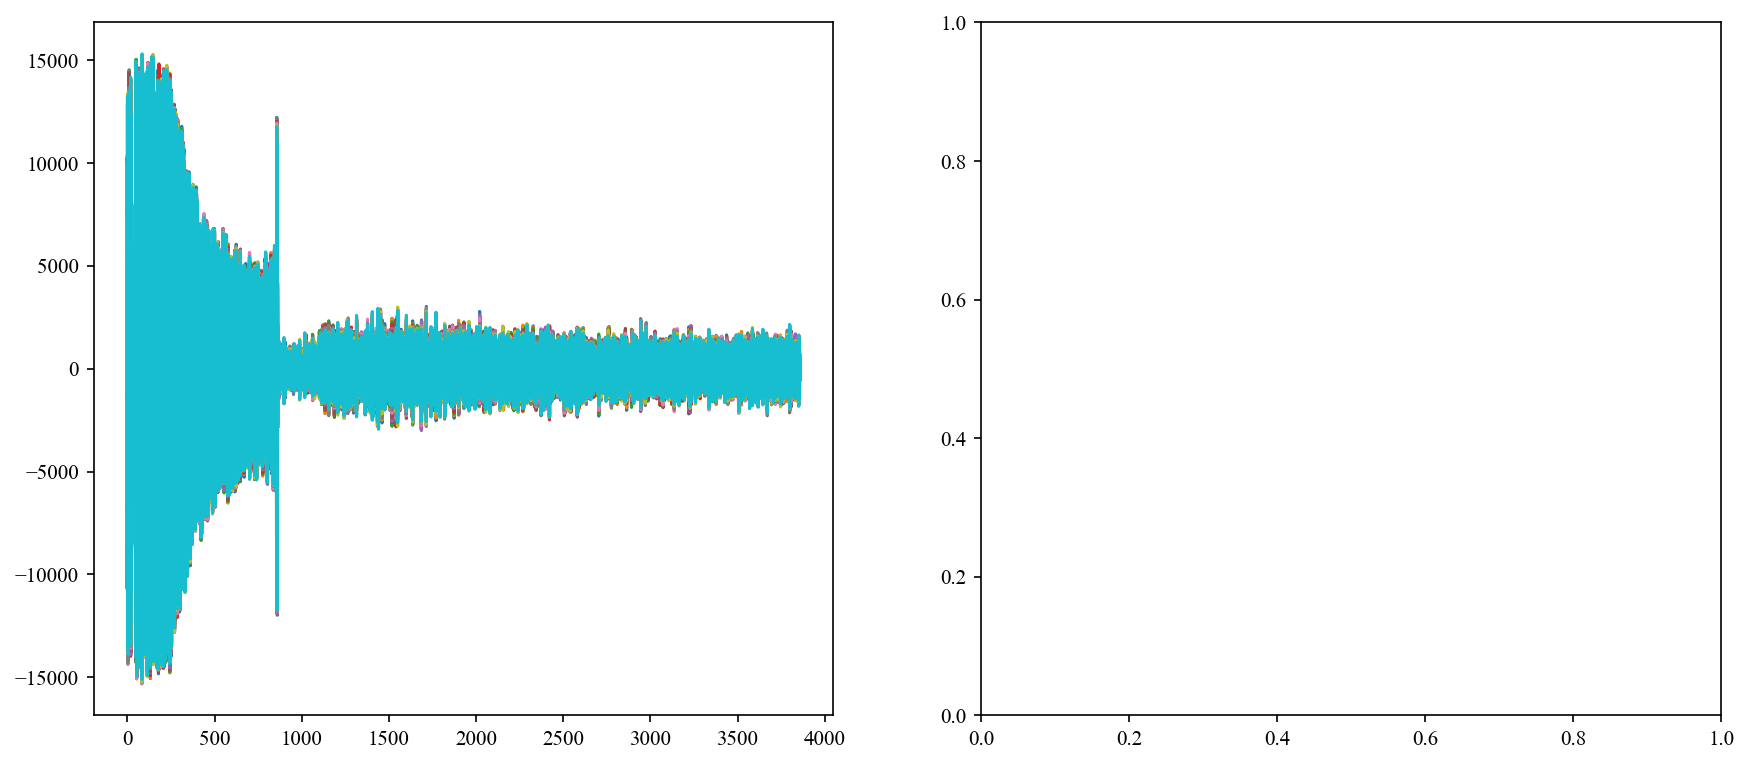

In [15]:
fig, ax = plt.subplots(figsize=[14, 6], nrows=1, ncols=2)

for i in range(10):
    ax[0].plot(R, data[i])

for i in range(az_samp[::100]):
    ax[1].plot(freq_mhz, 20*np.log10(abs(fft_data[i])))

ax[0].set_title(f'Time Avgd - {N} Avgs - No Header/Delay')
ax[0].set_xlabel('Range [m]')
ax[0].set_ylabel('Mag [Linear]')
ax[0].set_xlim(min(R), max(R))
ax[0].grid()

ax[1].set_title(f'Time Avgd - {N} Avgs - FFT')
ax[1].set_xlabel('Frequency [MHz]')
ax[1].set_ylabel('Mag [dB]')
ax[1].set_xlim(0, 480)
ax[1].grid()

plt.show()

In [16]:
# ###  Finding Azimuth FFT  ###

# az_samples = data.shape[0]
# T_az = 1/prf

# az_tmin = 0
# az_tmax = T_az*az_samples

# t_az = np.linspace(az_tmin, az_tmax, az_samples)
# R = t*c/2

# az_fft_data = np.fft.fftshift(np.fft.fft(data, axis=0))
# # fft_data = np.fft.fftshift(np.fft.fft(data_1, axis=1))
# # fft_many_avgs = np.fft.fftshift(np.fft.fft(many_avgs, axis=1))

# az_freq = np.linspace(-prf/2, prf/2, az_samples)
# freq_khz = az_freq/1e3

In [17]:
# plt.figure(figsize=(9, 6))


# for i in range(50):
#     plt.plot(az_freq, 20*np.log10(abs(az_fft_data[:, i])))


# plt.xlim(-100, 100)
# plt.grid()
# plt.show()

##  Filtering Data with Bandpass  ##

In [18]:
###  Filtering Data  ###

data = bandpass(data, 240e6, 320e6, fs, 3)
fft_data = np.fft.fftshift(np.fft.fft(data, axis=1))


##  Create Reference chirp for matched filter  ##

Chirp Samples: 5505


C:\Users\epsutherland\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


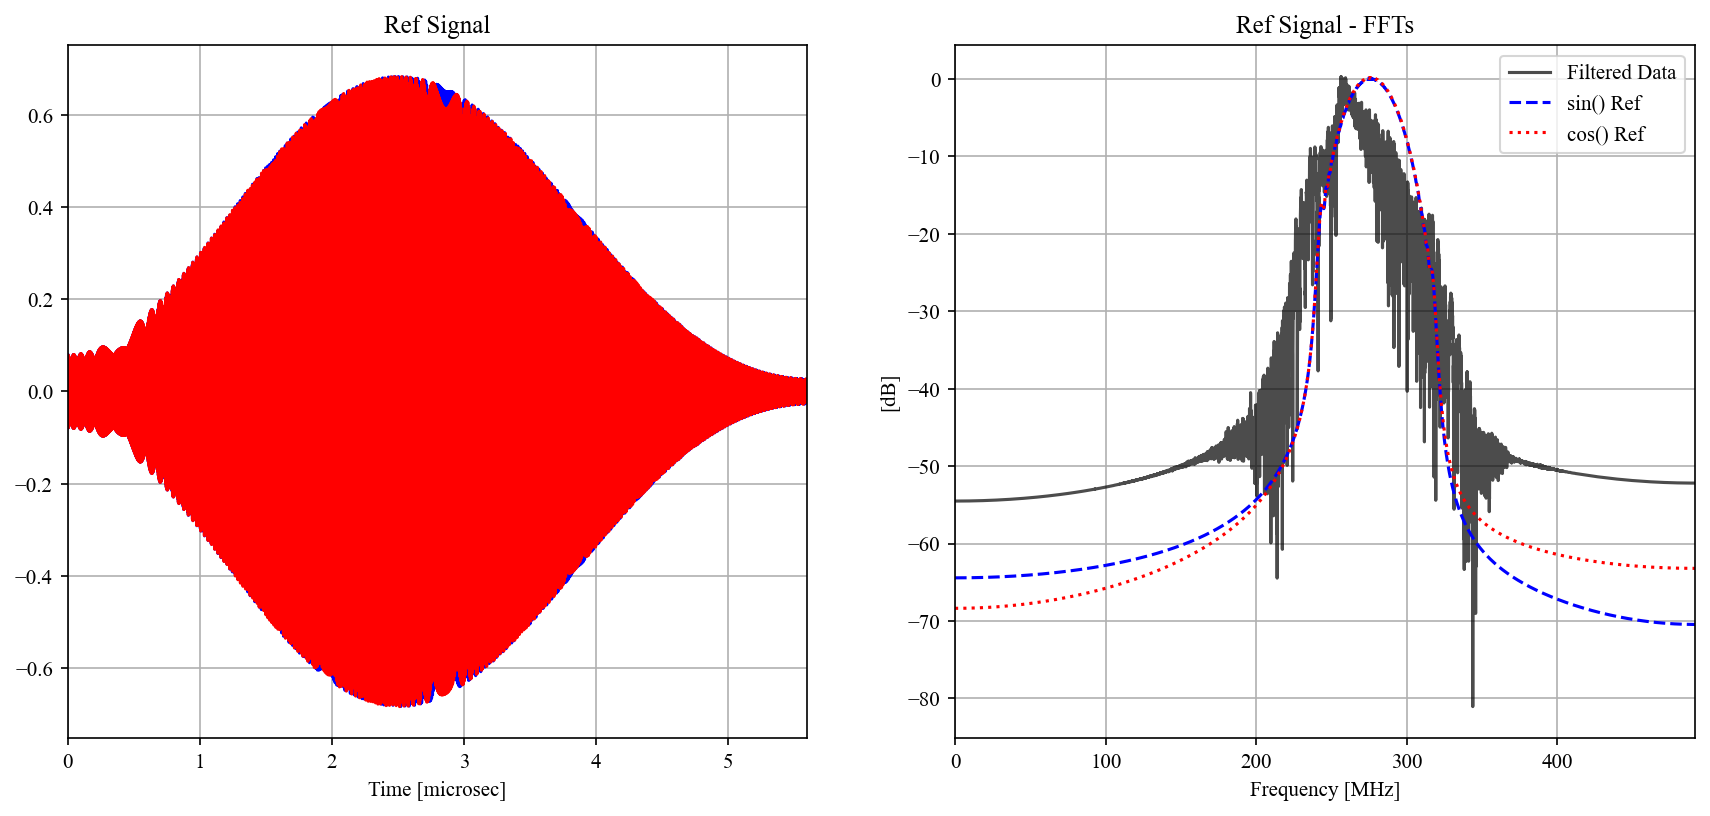

In [19]:
###  Creating Reference Signals for Compression  ###

# tp = H/c *2
tp = 5.6e-6
ref_samp = int(tp*fs)

t_ref = np.linspace(0, tp, ref_samp)
f_ref = np.linspace(-fs/2, fs/2, ref_samp)
print(f'Chirp Samples: {ref_samp}')

# ref_sig = chirp(t_ref, 180e6, t_ref[-1], 100e6, method='linear')#*np.hamming(49)
# ref_fft = np.fft.fftshift(np.fft.fft(ref_sig))
k = -80e6/tp



Amin = 5000/15000
Amax = 15000/15000
# Amin = 1
# Amax = 1


A = np.linspace(Amax, Amin, ref_samp)
# A = 0.1 + np.exp(-(t_ref*1e6))
hamming = np.hamming(ref_samp)
# sinChirp = hamming*A*chirp(t_ref, 480e6, t_ref[-1], 400e6, method='linear')
# cosChirp = hamming*A*chirp(t_ref, 480e6, t_ref[-1], 400e6, method='linear', phi=90)
sinChirp = hamming*A*chirp(t_ref, 240e6, t_ref[-1], 320e6, method='linear')
cosChirp = hamming*A*chirp(t_ref, 240e6, t_ref[-1], 320e6, method='linear', phi=90)


sin_fft = np.fft.fftshift(np.fft.fft(sinChirp)) 
cos_fft = np.fft.fftshift(np.fft.fft(cosChirp))


## Normalizing FFT's of all Data  ##
sin_fft = sin_fft / max(sin_fft)
cos_fft = cos_fft / max(cos_fft)
fft_data = fft_data / max(fft_data[1])


fig, ax = plt.subplots(figsize=[14, 6], nrows=1, ncols=2)
ax[0].plot(t_ref*1e6, sinChirp, color='b')
ax[0].plot(t_ref*1e6, cosChirp, color='r')

ax[1].plot(freq_mhz, 20*np.log10(fft_data[1]), color='k', alpha=0.7, label='Filtered Data')
ax[1].plot(f_ref/1e6, 20*np.log10(abs(sin_fft)), color='b', linestyle='--', label='sin() Ref')
ax[1].plot(f_ref/1e6, 20*np.log10(abs(cos_fft)), color='r', linestyle=':', label='cos() Ref')



ax[0].set_title('Ref Signal')
ax[0].set_xlabel('Time [microsec]')
ax[0].set_xlim(0, t_ref[-1]*1e6)
ax[0].grid()

ax[1].set_title('Ref Signal - FFTs')
ax[1].set_xlabel('Frequency [MHz]')
ax[1].set_ylabel('[dB]')
ax[1].set_xlim(0, max(freq_mhz))
# ax[1].set_ylim(0, 60)
ax[1].grid()
ax[1].legend()

plt.show()


##  Doing Range Compression  ##

In [20]:
###  RANGE COMPRESSION  ###

compressed = np.zeros_like(data)

for i in range(az_samp):
    sin_corr = signal.correlate(data[i], sinChirp, mode='same', method='fft')
    cos_corr = signal.correlate(data[i], cosChirp, mode='same', method='fft')
    compressed[i] = np.sqrt(sin_corr**2 + cos_corr**2)


# del(data)  ## Done with data, now only need range compressed version


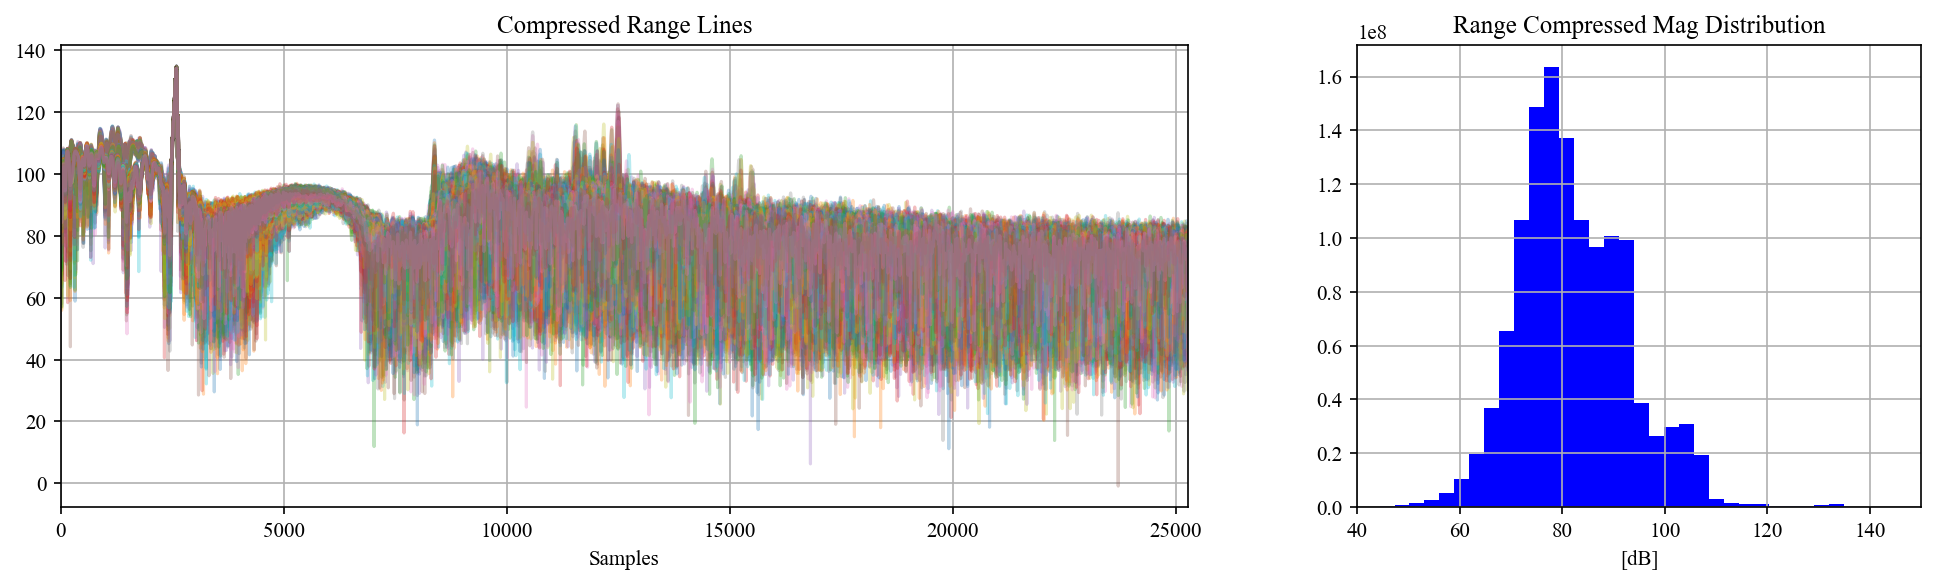

In [21]:
###  Plotting Compressed Range Lines and Magnitudes  ###

fig, ax = plt.subplots(figsize=[16, 4], nrows=1, ncols=2, 
                       gridspec_kw={
                           'width_ratios': [2, 1]
                       })



num_lines = compressed.shape[0]

for i in compressed[0::100]:
    ax[0].plot(20*np.log10(abs(i)), alpha=0.3)

ax[1].hist(20*np.log10(abs(compressed).flatten()), color='b', bins=50)


ax[0].set_title('Compressed Range Lines')
ax[0].set_xlabel('Samples')
ax[0].set_xlim(0, compressed.shape[1])
ax[0].grid()

ax[1].set_title('Range Compressed Mag Distribution')
ax[1].set_xlabel('[dB]')
ax[1].set_xlim(40, 150)

ax[1].grid()

plt.show()

In [22]:
print(compressed[0])

[42424.13911791 44384.28641648 46431.52260569 ...  5174.30318508
  4815.55655635  4473.36047751]


## After Range Compresion, doing Azimuth FFT  ##

In [23]:
###  Finding Azimuth FFT  ###

az_samples = compressed.shape[0]
T_az = 1/prf

az_tmin = 0
az_tmax = T_az*az_samples

t_az = np.linspace(az_tmin, az_tmax, az_samples)
R = t*c/2

az_fft_data = np.fft.fftshift(np.fft.fft(compressed, axis=0))
# fft_data = np.fft.fftshift(np.fft.fft(data_1, axis=1))
# fft_many_avgs = np.fft.fftshift(np.fft.fft(many_avgs, axis=1))

az_freq = np.linspace(-prf/2, prf/2, az_samples)
freq_khz = az_freq/1e3

In [24]:
# plt.figure(figsize=(9, 6))

# for i in range(300):
#     plt.plot(az_freq, 20*np.log10(abs(az_fft_data[:, i])))

# plt.xlim(-100, 100)
# plt.grid()
# plt.show()

In [25]:
# plt.figure(figsize=(9, 6))

# plt.imshow(20*np.log10(abs(az_fft_data)))

# plt.clim(110, 130)
# plt.colorbar()

# # plt.xlim(-100, 100)
# plt.grid()
# plt.show()

##  Truncating Swath  ##

In [26]:
start_R = H/np.cos(theta_ - 0.5*beamWidth)
stop_R = H/np.cos(theta_ + 0.5*beamWidth)

start_swath = int(2*(start_R/c)*fs)
stop_swath = int(2*(stop_R/c)*fs)

if stop_swath >= compressed.shape[1]:
    stop_swath = compressed.shape[1]

print(start_swath)
print(stop_swath)

7093
17125


In [58]:
start_swath = 7000
stop_swath = 20000

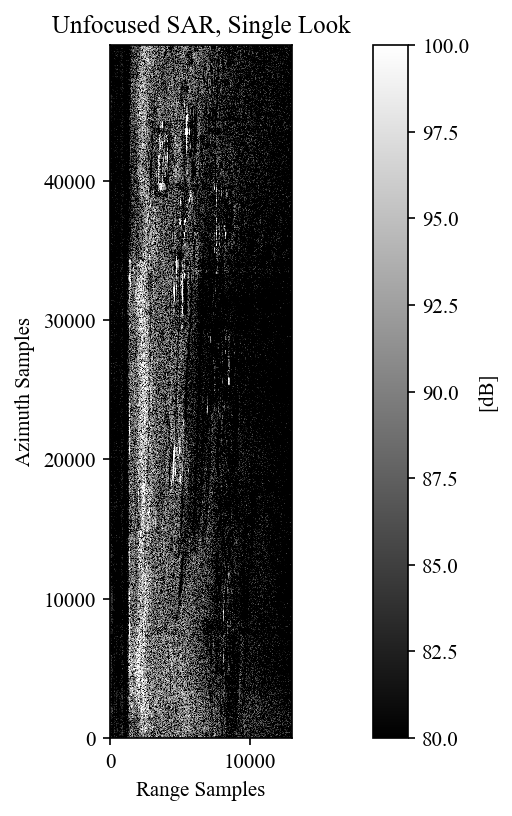

In [59]:
###  Range Compressed  ###

vmin = 80
vmax = 100

plt.figure(figsize=(14, 6))
plt.imshow(20*np.log10(abs(compressed[:, start_swath:stop_swath])), cmap='gray', interpolation='nearest', origin='lower')#, aspect='auto')

plt.title('Unfocused SAR, Single Look')
plt.xlabel('Range Samples')
plt.ylabel('Azimuth Samples')
plt.clim(vmin, vmax)
plt.colorbar(label='[dB]')
plt.show()

## Reducing Data Size to only include Swath  ##
#### Then making square pixels ####


In [60]:
###  Finding Azimuth pixel size  ###

# az_pix = N*vp/prf  ## azimuth pixel size in unfocused image
az_pix = vp/prf  ## azimuth pixel size in unfocused image

# r_pix = c*Ts
r_pix = c*Ts * np.cos(theta_)


print('Azimuth Pixel Size = ', az_pix, '[m]')
print('Range Pixel Size   = ', np.round(r_pix, 2), '[m]')
print('---------------------------------')

## Finding multilook factors for roughly square pixels  ##
if az_pix > r_pix:
    r_multilook = int(az_pix/r_pix)
    az_multilook = 1

    r_pix = r_multilook*r_pix

elif az_pix < r_pix:
    r_multilook = 1
    az_multilook = int(r_pix/az_pix)

    az_pix = az_multilook*az_pix

else:
    r_multilook = 1
    az_multilook = 1

# r_multilook = int(az_pix/r_pix)
print(f'Multilook Factors  = {r_multilook} x {az_multilook} [Range x Azimuth]')




Azimuth Pixel Size =  0.05 [m]
Range Pixel Size   =  0.22 [m]
---------------------------------
Multilook Factors  = 1 x 4 [Range x Azimuth]


In [61]:
swath = multilook(abs(compressed[:-3, start_swath:stop_swath]), r_multilook, az_multilook)

N_az = swath.shape[0]
N_r = swath.shape[1]


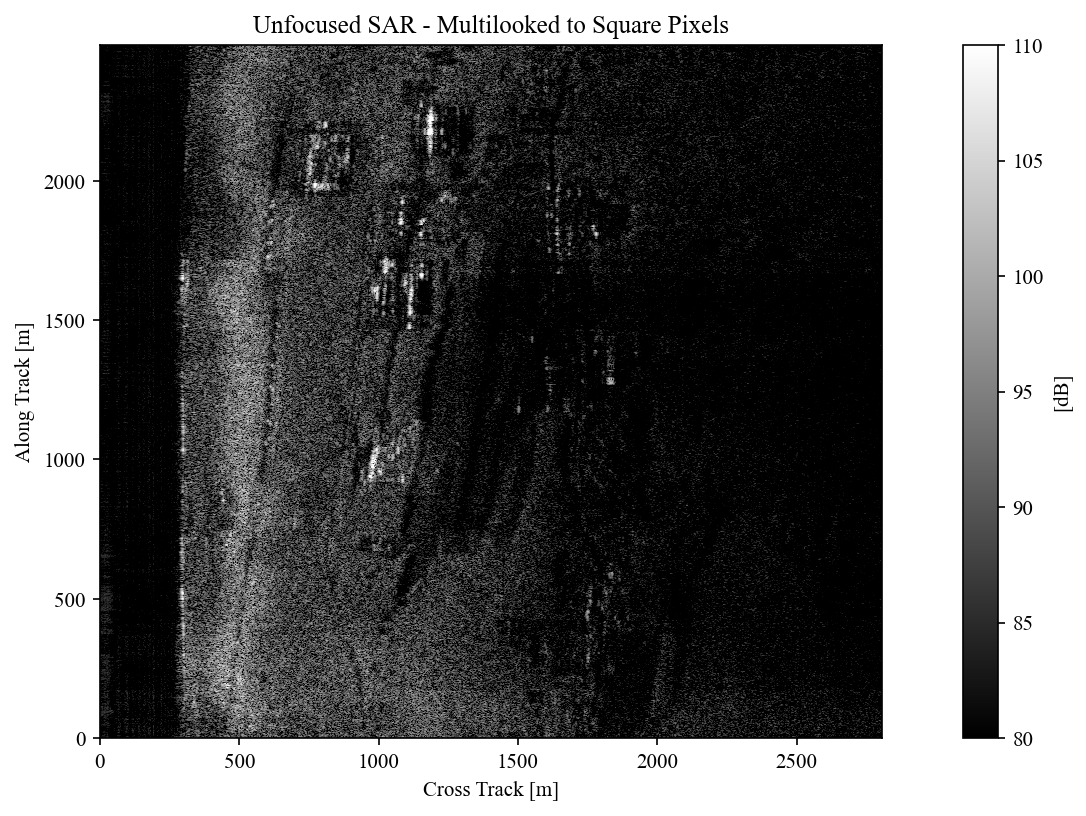

In [62]:
vmin = 80
vmax = 110

plt.figure(figsize=(14, 6))
plt.imshow(20*np.log10(abs(swath)), cmap='gray', interpolation='nearest', origin='lower', extent=[0, r_pix*N_r, 0, az_pix*N_az])#, aspect='auto')

plt.title('Unfocused SAR - Multilooked to Square Pixels')
plt.ylabel('Along Track [m]')
plt.xlabel('Cross Track [m]')
plt.clim(vmin, vmax)
plt.colorbar(label='[dB]')
plt.show()

##  Correcting Range Loss  ##
####  SLAR Radar Range Equation  ####

$ P_r = \dfrac{P_t G^2 \lambda^2 \beta_h c \tau_p}{2(4 \pi)^3 R^3 sin \theta} $

In [63]:


R_loss = np.tile(np.linspace(r_pix + H, N_r*r_pix + H, N_r), (N_az, 1))  ## Creating matrix of ranges

norm_swath = swath*R_loss**2


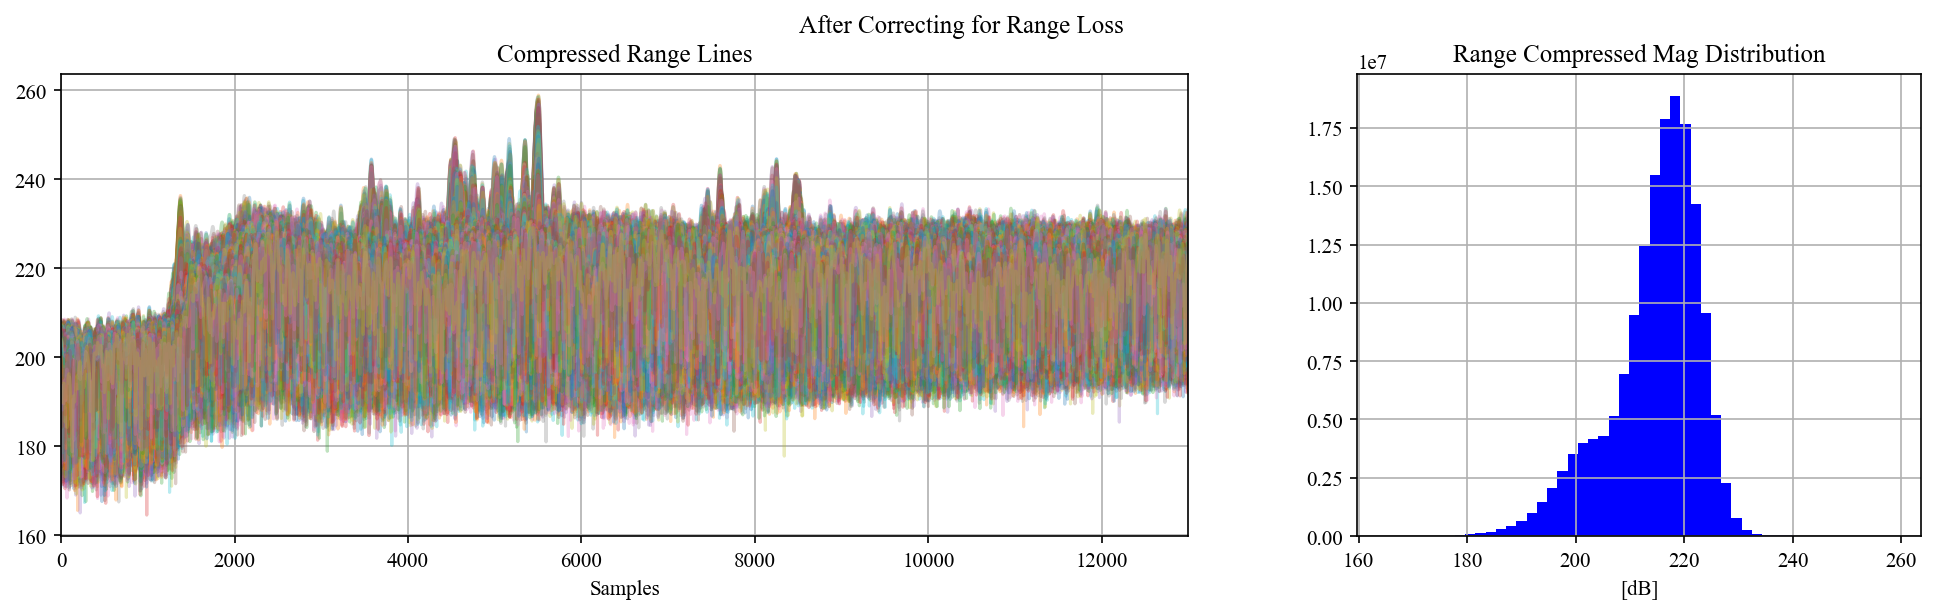

In [64]:
###  Plotting Compressed Range Lines and Magnitudes  ###

fig, ax = plt.subplots(figsize=[16, 4], nrows=1, ncols=2, 
                       gridspec_kw={
                           'width_ratios': [2, 1]
                       })




# for i in range(num_lines[0::2]):
for i in norm_swath[0::4]:
    ax[0].plot(20*np.log10(abs(i)), alpha=0.3)

ax[1].hist(20*np.log10(abs(norm_swath).flatten()), color='b', bins=50)

ax[0].set_title('Compressed Range Lines')
ax[0].set_xlabel('Samples')
ax[0].set_xlim(0, norm_swath.shape[1])
ax[0].grid()

ax[1].set_title('Range Compressed Mag Distribution')
ax[1].set_xlabel('[dB]')
ax[1].grid()

fig.suptitle('After Correcting for Range Loss')
plt.show()

## Now doing some incoherent averaging for comparison ##

In [65]:
m = 10
multilooked = multilook(abs(norm_swath[:-4, :]), m, m)

In [66]:
##  Plotting SLC and MLC side by side  ##

# vmin = 210
# vmax = 235
# # vmin = 270
# # vmax = 305

# fig, ax = plt.subplots(1, 2, figsize=(9, 9))
# im1 = ax[0].imshow(20*np.log10(abs(norm_swath)), cmap='gray', interpolation='nearest', origin='lower', vmin=vmin, vmax=vmax, extent=[0, r_pix*N_r, 0, az_pix*N_az])#, aspect='auto')
# ax[0].set_title('Single Look - Unfocused SAR')
# ax[0].set_ylabel('Along Track [m]')
# ax[0].set_xlabel('Cross Track [m]')

# im2 = ax[1].imshow(20*np.log10(abs(multilooked)), cmap='gray', interpolation='none', origin='lower', vmin=vmin, vmax=vmax, extent=[0, r_pix*N_r, 0, az_pix*N_az])#, aspect='auto')
# ax[1].set_title(f'Multilooked {m}x{m}')
# ax[1].set_ylabel('Along Track [m]')
# ax[1].set_xlabel('Cross Track [m]')
# fig.colorbar(im2, ax=ax[1], label='[dB]')

# # fig.suptitle(f'BonanW - Sept 13, 2019')
# plt.show()

In [67]:
multilooked.shape

(1243, 1300)

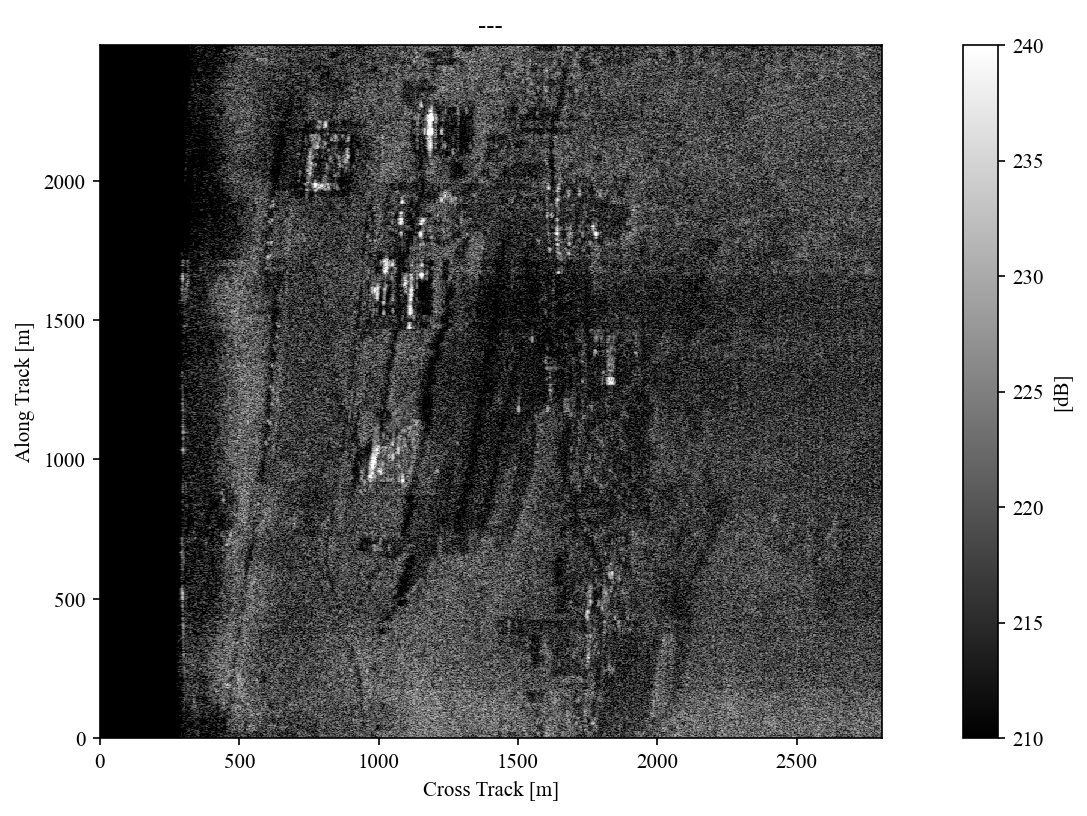

In [71]:
vmin = 210
vmax = 240

plt.figure(figsize=(14, 6))
plt.imshow(20*np.log10(abs(multilooked)), cmap='gray', interpolation='nearest', origin='lower', extent=[0, r_pix*N_r, 0, az_pix*N_az])#, aspect='auto')

plt.title('---')
plt.ylabel('Along Track [m]')
plt.xlabel('Cross Track [m]')
plt.clim(vmin, vmax)
plt.colorbar(label='[dB]')
plt.show()

In [ ]:
print(norm_swath.shape)

In [ ]:
# %matplotlib inline

# vmin = 205
# vmax = 245

# plt.figure(figsize=(6, 9))
# plt.imshow(20*np.log10(abs(norm_swath)), cmap='gray', interpolation='nearest', origin='lower', extent=[0, r_pix*N_r, 0, az_pix*N_az])#, aspect='auto')

# plt.title('Unfocused SAR')
# plt.ylabel('Along Track [m]')
# plt.xlabel('Cross Track [m]')

# plt.clim(vmin, vmax)
# plt.colorbar(label='[dB]')

# ###  Saving Image  ###

# # image_file = f'CBand_UnfocusedSAR_Fewer_avgs.png'
# # cwd = os.getcwd()

# # plt.savefig(os.path.join(cwd, image_file), dpi=500, bbox_inches='tight', pad_inches=0, transparent=True)

# plt.show()


In [ ]:
# %matplotlib widget

# multilooked = multilook(abs(norm_swath), m, m)

# # vmin = 200
# # vmax = 250

# plt.figure(figsize=(6, 9))
# plt.imshow(20*np.log10(abs(multilooked)), cmap='gray', interpolation='none', origin='lower', extent=[0, r_pix*N_r, 0, az_pix*N_az])#, aspect='auto')

# plt.title('Unfocused SAR')
# plt.ylabel('Along Track [m]')
# plt.xlabel('Cross Track [m]')

# plt.clim(vmin, vmax)
# plt.colorbar(label='[dB - Uncal.]')

# ###  Saving Image  ###

# image_file = f'CBand_UnfocusedSAR_1000m_Multilooked_NewFilter.png'
# cwd = os.getcwd()

# plt.savefig(os.path.join(cwd, image_file), dpi=500, bbox_inches='tight', pad_inches=0, transparent=True)

# plt.show()

In [ ]:
%matplotlib inline


In [ ]:
# Define the reference coordinates

# # NH
# ref_latitude =  43.27278
# ref_longitude = -70.9155

# # Create an empty KML object
# kml = Kml()

# # Create a ground overlay for the image
# ground_overlay = kml.newgroundoverlay(name='GroundOverlay')

# # Set the image as the overlay's icon
# ground_overlay.icon.href = image_file

# # Calculate the bounding box coordinates in degrees
# lat_range = 4500
# lon_range = 2000

# min_lat = ref_latitude - (lat_range/ 111320)  # Approximate degrees per meter
# max_lat = ref_latitude + (lat_range / 111320)
# min_lon = ref_longitude - (lon_range / (111320 * np.cos(np.radians(ref_latitude))))
# max_lon = ref_longitude + (lon_range / (111320 * np.cos(np.radians(ref_latitude))))

# # Define the bounding box coordinates
# ground_overlay.latlonbox.north = max_lat
# ground_overlay.latlonbox.south = min_lat
# ground_overlay.latlonbox.east = max_lon
# ground_overlay.latlonbox.west = min_lon
# ground_overlay.latlonbox.rotation = -124


# # Save the KML file
# kml.save(f'{image_file[:-4]}.kml')

# print("KML file created successfully.")

# kml.savekmz(f'{image_file[:-4]}.kmz')

In [ ]:
# multilooked.tofile('Multilooked_UnfocusedSAR', sep='')
# np.savetxt('Multilooked_UnfocusedSAR.txt', multilooked)

In [ ]:
print(N_r)
print(N_az)
print(r_pix)
print(az_pix)